# ===============================
# De-ID + Quality Check Pipeline
# Dataset: LUNA16 (subset0)
# OS: Windows
# Environment: JupyterLab
# ===============================


In [4]:
# ===============================
# De-ID + Quality Check Pipeline
# Dataset: LUNA16 (subset0)
# OS: Windows
# Environment: JupyterLab
# ===============================

import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------------
# 1. PATH CONFIGURATION (WINDOWS)
# -------------------------------
RAW_DATA_PATH = r"C:\Users\Harsh\lung_cancer_detection\data\raw\subset0"

assert os.path.exists(RAW_DATA_PATH), "Dataset path not found!"

# -------------------------------
# 2. LOAD CT SCAN
# -------------------------------
def load_ct(mhd_path):
    return sitk.ReadImage(mhd_path)

# -------------------------------
# 3. DE-IDENTIFICATION
# -------------------------------
def deidentify_ct(image):
    img = sitk.Image(image)
    img.SetMetaData("PatientName", "ANON")
    img.SetMetaData("PatientID", "ANON")
    return img

# -------------------------------
# 4. CT TO NUMPY
# -------------------------------
def ct_to_numpy(image):
    return sitk.GetArrayFromImage(image)  # [Z, Y, X]

# -------------------------------
# 5. QUALITY CHECK
# -------------------------------
def quality_check(img_np):
    return {
        "shape": img_np.shape,
        "min_hu": float(np.min(img_np)),
        "max_hu": float(np.max(img_np)),
        "mean_hu": float(np.mean(img_np)),
        "has_nan": bool(np.isnan(img_np).any())
    }

# -------------------------------
# 6. VISUAL QC
# -------------------------------
def show_middle_slice(img_np, title="CT Slice"):
    z = img_np.shape[0] // 2
    plt.figure(figsize=(5, 5))
    plt.imshow(img_np[z], cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# -------------------------------
# 7. MAIN PIPELINE
# -------------------------------
mhd_files = [f for f in os.listdir(RAW_DATA_PATH) if f.endswith(".mhd")]
print(f"Total CT scans found: {len(mhd_files)}")

deid_scans = {}
qc_results = []

for fname in tqdm(mhd_files, desc="Processing scans"):
    path = os.path.join(RAW_DATA_PATH, fname)

    ct = load_ct(path)                 # Load
    ct_deid = deidentify_ct(ct)         # De-ID
    ct_np = ct_to_numpy(ct_deid)        # To NumPy

    qc = quality_check(ct_np)           # QC
    qc["scan_id"] = fname

    deid_scans[fname] = ct_deid
    qc_results.append(qc)

# -------------------------------
# 8. QC REPORT
# -------------------------------
qc_df = pd.DataFrame(qc_results)
qc_df


Total CT scans found: 89


Processing scans: 100%|██████████| 89/89 [00:33<00:00,  2.62it/s]


,shape,min_hu,max_hu,mean_hu,has_nan,scan_id
0,"(121, 512, 512)",-3024.0,2103.0,-1035.623523,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...
1,"(119, 512, 512)",-2048.0,3071.0,-768.509276,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...
2,"(161, 512, 512)",-3024.0,2211.0,-869.393674,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...
3,"(538, 512, 512)",-3024.0,2054.0,-892.305554,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...
4,"(124, 512, 512)",-3024.0,3071.0,-1024.476810,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...
...,...,...,...,...,...,...
84,"(246, 512, 512)",-2048.0,3071.0,-887.034628,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413...
85,"(200, 512, 512)",-1000.0,3000.0,-357.251005,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028...
86,"(152, 512, 512)",-2048.0,3071.0,-837.881639,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...
87,"(124, 512, 512)",-3024.0,2040.0,-966.977421,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136...


In [7]:
HU_MIN, HU_MAX = -1200, 600

bad_scans = qc_df[
    (qc_df["min_hu"] < HU_MIN) |
    (qc_df["max_hu"] > HU_MAX) |
    (qc_df["has_nan"])
]

print(f"Bad scans detected: {len(bad_scans)}")
bad_scans


Bad scans detected: 89


,shape,min_hu,max_hu,mean_hu,has_nan,scan_id
0,"(121, 512, 512)",-3024.0,2103.0,-1035.623523,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...
1,"(119, 512, 512)",-2048.0,3071.0,-768.509276,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...
2,"(161, 512, 512)",-3024.0,2211.0,-869.393674,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...
3,"(538, 512, 512)",-3024.0,2054.0,-892.305554,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...
4,"(124, 512, 512)",-3024.0,3071.0,-1024.476810,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...
...,...,...,...,...,...,...
84,"(246, 512, 512)",-2048.0,3071.0,-887.034628,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413...
85,"(200, 512, 512)",-1000.0,3000.0,-357.251005,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028...
86,"(152, 512, 512)",-2048.0,3071.0,-837.881639,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588...
87,"(124, 512, 512)",-3024.0,2040.0,-966.977421,False,1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136...


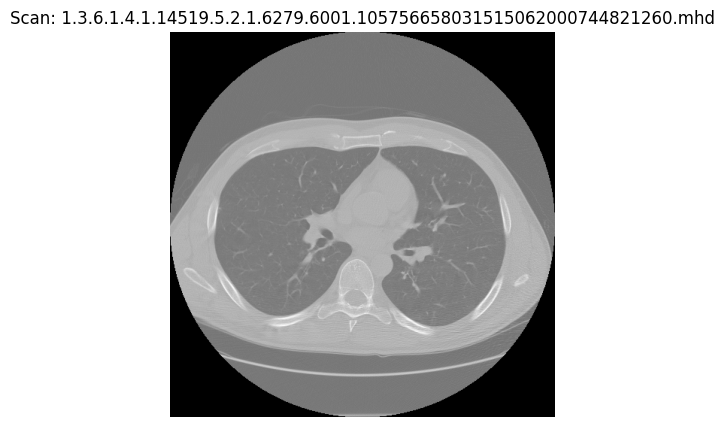

In [8]:
sample_scan_id = qc_df.iloc[0]["scan_id"]
sample_np = ct_to_numpy(deid_scans[sample_scan_id])

show_middle_slice(sample_np, title=f"Scan: {sample_scan_id}")


# RESAMPLING + HU PREPROCESSING

In [9]:
import os
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm


In [10]:
RAW_DATA_PATH = r"C:\Users\Harsh\lung_cancer_detection\data\raw\subset0"

In [11]:
def load_ct(mhd_path):
    return sitk.ReadImage(mhd_path)


In [12]:
def resample_ct(image, new_spacing=[1.0, 1.0, 1.0]):
    """
    Resample CT scan to isotropic voxel spacing
    """
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()

    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetDefaultPixelValue(-1024)

    return resampler.Execute(image)


In [13]:
def ct_to_numpy(image):
    return sitk.GetArrayFromImage(image)  # [Z, Y, X]


In [14]:
def hu_clip(img_np, hu_min=-1000, hu_max=400):
    return np.clip(img_np, hu_min, hu_max)


In [15]:
def normalize(img_np, hu_min=-1000, hu_max=400):
    img_np = (img_np - hu_min) / (hu_max - hu_min)
    return img_np.astype(np.float32)


In [16]:
mhd_files = [f for f in os.listdir(RAW_DATA_PATH) if f.endswith(".mhd")]
print(f"Total scans found: {len(mhd_files)}")

preprocessed_scans = {}

for fname in tqdm(mhd_files, desc="Resampling & preprocessing"):
    path = os.path.join(RAW_DATA_PATH, fname)

    # Load
    ct = load_ct(path)

    # Resample
    ct_resampled = resample_ct(ct)

    # Convert to NumPy
    ct_np = ct_to_numpy(ct_resampled)

    # HU Clip
    ct_np = hu_clip(ct_np)

    # Normalize
    ct_np = normalize(ct_np)

    preprocessed_scans[fname] = ct_np


Total scans found: 89


Resampling & preprocessing: 100%|██████████| 89/89 [00:55<00:00,  1.60it/s]


In [17]:
sample_id = list(preprocessed_scans.keys())[0]
sample = preprocessed_scans[sample_id]

print("Shape:", sample.shape)
print("Min:", sample.min(), "Max:", sample.max())


Shape: (302, 390, 390)
Min: 0.0 Max: 1.0


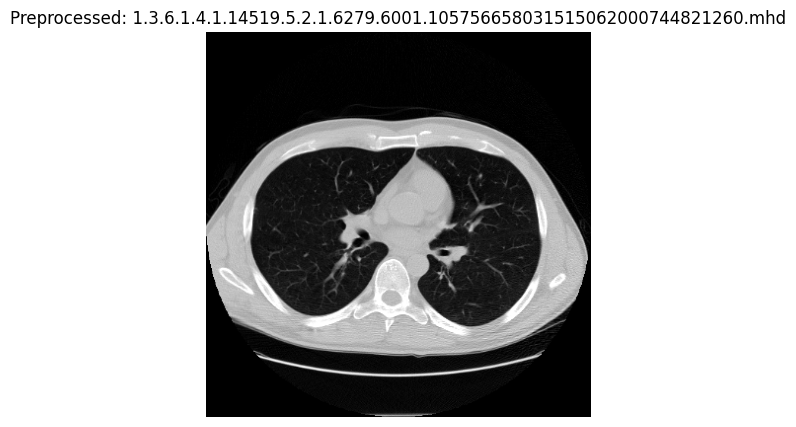

In [18]:
import matplotlib.pyplot as plt

def show_middle_slice(img_np, title=""):
    z = img_np.shape[0] // 2
    plt.figure(figsize=(5,5))
    plt.imshow(img_np[z], cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

show_middle_slice(sample, title=f"Preprocessed: {sample_id}")


# Lung Masking

In [19]:
# =========================================
# ROBUST LUNG MASKING + SAVE (ONE CELL)
# Dataset: LUNA16 subset0
# =========================================

import os
import numpy as np
import SimpleITK as sitk
import scipy.ndimage as ndi
from skimage import measure
from tqdm import tqdm

# -----------------------------------------
# PATHS
# -----------------------------------------
RAW_DATA_PATH = r"C:\Users\Harsh\lung_cancer_detection\data\raw\subset0"
BASE_OUT = r"C:\Users\Harsh\lung_cancer_detection\data\processed"

MASK_OUT = os.path.join(BASE_OUT, "lung_mask")
LUNG_OUT = os.path.join(BASE_OUT, "lung_only")

os.makedirs(MASK_OUT, exist_ok=True)
os.makedirs(LUNG_OUT, exist_ok=True)

# -----------------------------------------
# LOAD + RESAMPLE
# -----------------------------------------
def load_and_resample_ct(mhd_path, new_spacing=(1.0, 1.0, 1.0)):
    img = sitk.ReadImage(mhd_path)

    original_spacing = img.GetSpacing()
    original_size = img.GetSize()

    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(img.GetDirection())
    resampler.SetOutputOrigin(img.GetOrigin())
    resampler.SetDefaultPixelValue(-1024)

    return resampler.Execute(img)

# -----------------------------------------
# ROBUST LUNG MASK (HU SPACE + FALLBACK)
# -----------------------------------------
def segment_lung_mask_robust(volume_hu):
    """
    Robust classical lung segmentation with adaptive threshold + fallback
    """

    # 1. Air threshold
    binary = volume_hu < -320

    # 2. Label connected components
    labels = measure.label(binary, connectivity=1)

    # Remove background air
    background_label = labels[0, 0, 0]
    binary[labels == background_label] = 0

    lung_mask = np.zeros_like(binary, dtype=np.uint8)

    regions = measure.regionprops(labels)

    if len(regions) > 0:
        areas = [r.area for r in regions]
        max_area = max(areas)

        # Adaptive area threshold
        area_threshold = max(5000, int(0.1 * max_area))

        for region in regions:
            if region.area >= area_threshold:
                lung_mask[labels == region.label] = 1

    # 3. Fill holes slice-wise
    for i in range(lung_mask.shape[0]):
        lung_mask[i] = ndi.binary_fill_holes(lung_mask[i])

    # 4. FALLBACK: if mask is empty
    if lung_mask.sum() == 0:
        for i in range(volume_hu.shape[0]):
            slice_bin = volume_hu[i] < -320
            slice_bin = ndi.binary_fill_holes(slice_bin)
            lung_mask[i] = slice_bin.astype(np.uint8)

    return lung_mask

# -----------------------------------------
# PROCESS + SAVE ALL SCANS
# -----------------------------------------
mhd_files = [f for f in os.listdir(RAW_DATA_PATH) if f.endswith(".mhd")]
print("Total scans:", len(mhd_files))

empty_count = 0

for fname in tqdm(mhd_files, desc="Masking & saving"):
    base_name = fname.replace(".mhd", "")
    path = os.path.join(RAW_DATA_PATH, fname)

    # Load & resample
    ct = load_and_resample_ct(path)
    ct_hu = sitk.GetArrayFromImage(ct)

    # Lung mask
    mask = segment_lung_mask_robust(ct_hu)

    if mask.sum() == 0:
        empty_count += 1

    # Apply mask
    lung_only = ct_hu * mask

    # Save
    np.save(os.path.join(MASK_OUT, base_name + "_mask.npy"), mask)
    np.save(os.path.join(LUNG_OUT, base_name + "_lung.npy"), lung_only)

print("✅ Lung masks and lung-only volumes saved successfully.")
print(f"⚠️ Empty masks after fallback: {empty_count}")


Total scans: 89


Masking & saving: 100%|██████████| 89/89 [03:33<00:00,  2.40s/it]

✅ Lung masks and lung-only volumes saved successfully.
⚠️ Empty masks after fallback: 0


In [23]:
import numpy as np, os

empty = []
for f in os.listdir(MASK_OUT):
    m = np.load(os.path.join(MASK_OUT, f))
    if m.sum() == 0:
        empty.append(f)

print("Empty masks:", len(empty))


Empty masks: 0


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
BASE_OUT = r"C:\Users\Harsh\lung_cancer_detection\data\processed"
MASK_OUT = os.path.join(BASE_OUT, "lung_mask")
LUNG_OUT = os.path.join(BASE_OUT, "lung_only")
def visualize_saved_lung(mask, lung, slice_idx=None, title=""):
    """
    Visualize lung CT with its mask
    """
    if slice_idx is None:
        slice_idx = mask.shape[0] // 2

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(mask[slice_idx], cmap="gray")
    plt.title("Lung Mask")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(lung[slice_idx], cmap="gray")
    plt.title("Lung Only")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(lung[slice_idx] * mask[slice_idx], cmap="gray")
    plt.title("Mask Applied")
    plt.axis("off")

    plt.suptitle(title)
    plt.show()


In [25]:
def visualize_all_lung_cts(mask_dir, lung_dir, slice_idx=None, max_scans=None):
    """
    Visualize all lung CTs with their masks

    Parameters:
    - mask_dir: path to lung_mask folder
    - lung_dir: path to lung_only folder
    - slice_idx: specific slice (None = middle slice)
    - max_scans: limit number of scans to display (for safety)
    """
    mask_files = sorted(os.listdir(mask_dir))

    if max_scans:
        mask_files = mask_files[:max_scans]

    print(f"Visualizing {len(mask_files)} scans...\n")

    for i, mask_file in enumerate(mask_files, 1):
        lung_file = mask_file.replace("_mask.npy", "_lung.npy")

        mask_path = os.path.join(mask_dir, mask_file)
        lung_path = os.path.join(lung_dir, lung_file)

        mask = np.load(mask_path)
        lung = np.load(lung_path)

        title = f"{i}. {mask_file.replace('_mask.npy','')}"
        visualize_saved_lung(mask, lung, slice_idx=slice_idx, title=title)


Visualizing 10 scans...



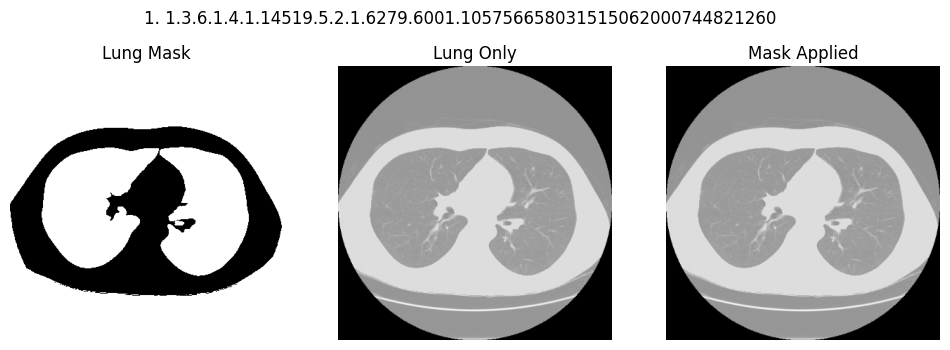

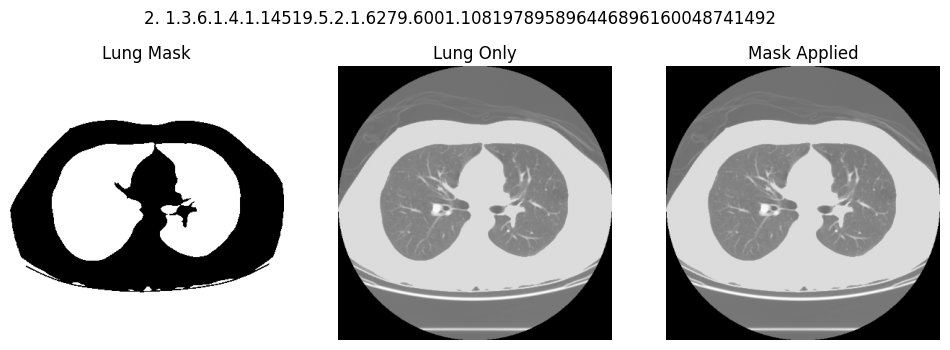

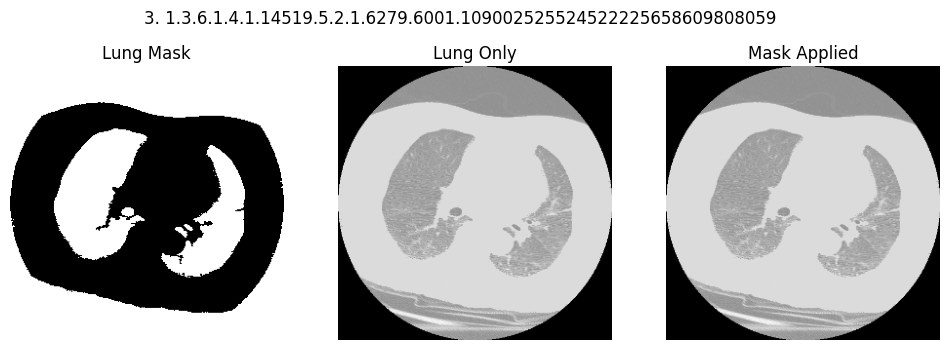

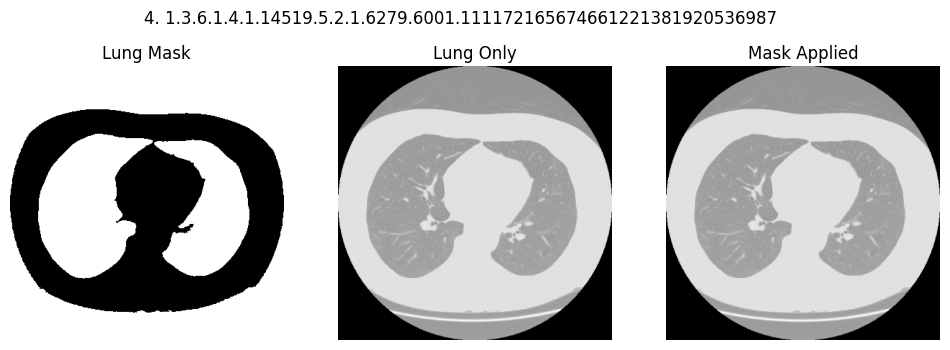

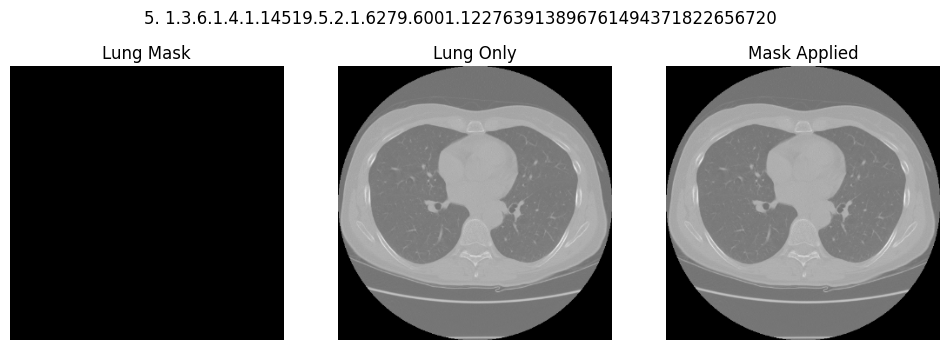

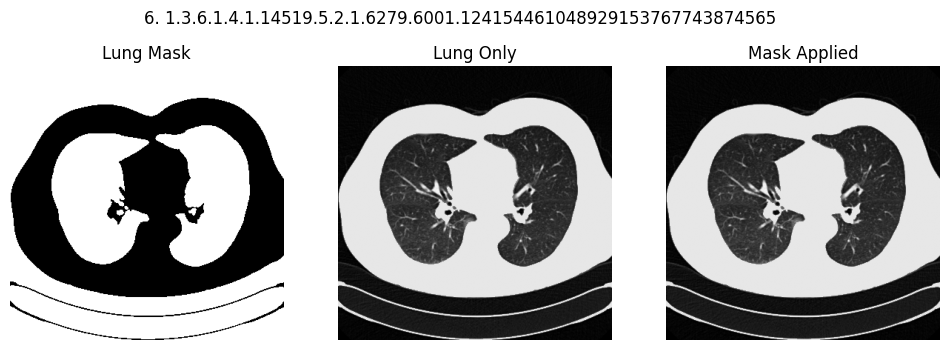

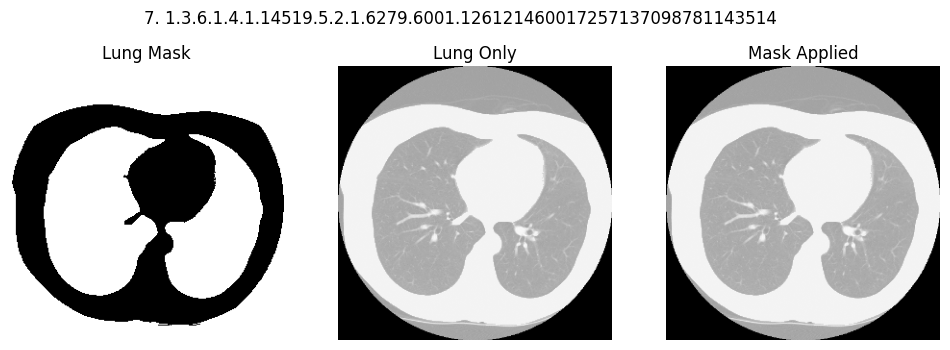

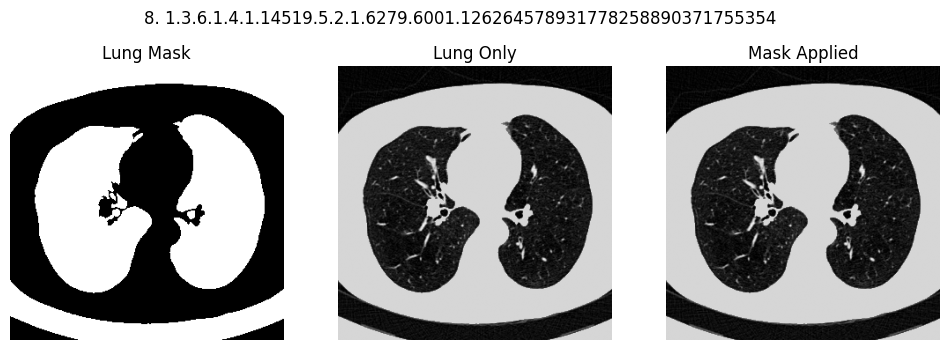

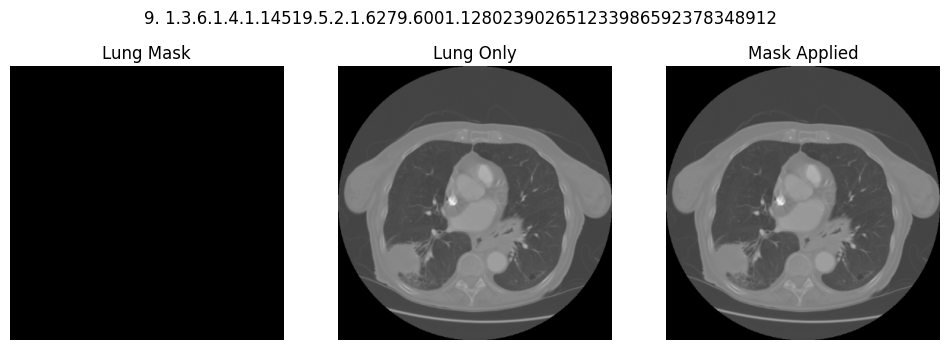

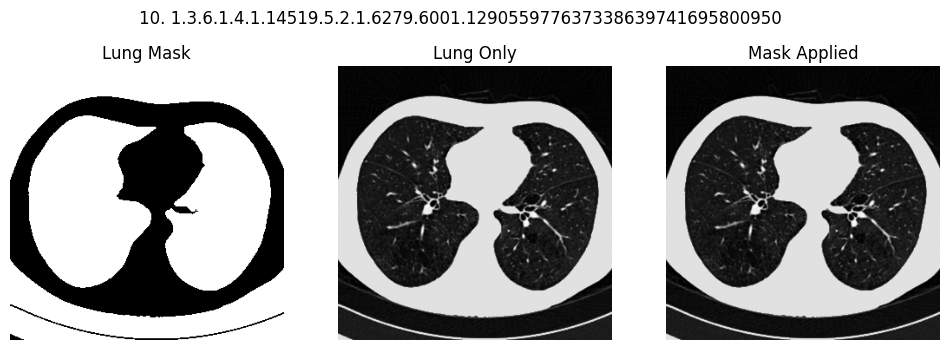

In [26]:
visualize_all_lung_cts(MASK_OUT, LUNG_OUT, max_scans=10)


In [27]:
def segment_lung_mask_robust(volume_hu):
    """
    Robust classical lung segmentation with fallback
    """
    # 1. Initial threshold
    binary = volume_hu < -320

    # 2. Remove background air
    labels = measure.label(binary, connectivity=1)
    background_label = labels[0, 0, 0]
    binary[labels == background_label] = 0

    # 3. Keep large connected components (adaptive)
    lung_mask = np.zeros_like(binary, dtype=np.uint8)

    areas = [r.area for r in measure.regionprops(labels)]
    if len(areas) == 0:
        return lung_mask  # nothing detected

    max_area = max(areas)
    area_threshold = max(5000, int(0.1 * max_area))  # adaptive threshold

    for region in measure.regionprops(labels):
        if region.area >= area_threshold:
            lung_mask[labels == region.label] = 1

    # 4. Fill holes slice-wise
    for i in range(lung_mask.shape[0]):
        lung_mask[i] = ndi.binary_fill_holes(lung_mask[i])

    # 5. FALLBACK: if still empty → slice-wise air detection
    if lung_mask.sum() == 0:
        for i in range(volume_hu.shape[0]):
            slice_bin = volume_hu[i] < -320
            slice_bin = ndi.binary_fill_holes(slice_bin)
            lung_mask[i] = slice_bin.astype(np.uint8)

    return lung_mask


# Data subset0 filteration

In [1]:
import pandas as pd

CAND_CSV = r"C:\Users\Harsh\lung_cancer_detection\data\processed\candidates.csv"

candidates_df = pd.read_csv(CAND_CSV)
print("Total candidates:", len(candidates_df))
candidates_df.head()


Total candidates: 551065


,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


In [2]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd


In [3]:
# Paths
RAW_SUBSET_DIR = r"C:\Users\Harsh\lung_cancer_detection\data\raw\subset0"
PROCESSED_DIR = r"C:\Users\Harsh\lung_cancer_detection\data\processed"

LUNG_DIR = os.path.join(PROCESSED_DIR, "lung_only")
MASK_DIR = os.path.join(PROCESSED_DIR, "lung_mask")

# Load candidates CSV
CAND_CSV = r"C:\Users\Harsh\lung_cancer_detection\data\processed\candidates.csv"
candidates_df = pd.read_csv(CAND_CSV)

print("Total candidates:", len(candidates_df))


Total candidates: 551065


In [4]:
def world_to_voxel(world_coord, origin, spacing, direction):
    """
    Convert world (mm) coordinates to voxel indices
    """
    direction = np.array(direction).reshape(3, 3)
    spacing = np.array(spacing)
    origin = np.array(origin)

    # World to image coordinate
    voxel = np.linalg.inv(direction).dot(world_coord - origin) / spacing
    return np.round(voxel).astype(int)


In [5]:
import os

# Get all available seriesuids from subset0
subset0_files = [
    f.replace(".mhd", "")
    for f in os.listdir(RAW_SUBSET_DIR)
    if f.endswith(".mhd")
]

subset0_series = set(subset0_files)

print("Subset0 scans:", len(subset0_series))


Subset0 scans: 89


In [6]:
# Filter candidates to subset0 only
candidates_subset0 = candidates_df[
    candidates_df["seriesuid"].isin(subset0_series)
].reset_index(drop=True)

print("Candidates in subset0:", len(candidates_subset0))
candidates_subset0.head()


Candidates in subset0: 56938


,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,129.568151,45.377097,-277.835758,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-97.260000,56.360000,-201.930000,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,99.230491,-4.882165,-128.691305,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,-15.287525,-59.105100,-251.303750,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,109.344666,1.891737,-237.284699,0


In [7]:
# Pick one valid series from subset0
seriesuid = candidates_subset0.iloc[0]["seriesuid"]
print("Testing series:", seriesuid)

mhd_path = os.path.join(RAW_SUBSET_DIR, seriesuid + ".mhd")
print("File exists:", os.path.exists(mhd_path))

img = sitk.ReadImage(mhd_path)

origin = img.GetOrigin()
spacing = img.GetSpacing()
direction = img.GetDirection()

row = candidates_subset0.iloc[0]
world_coord = np.array([row.coordX, row.coordY, row.coordZ])

voxel_coord = world_to_voxel(world_coord, origin, spacing, direction)

print("World coord:", world_coord)
print("Voxel coord:", voxel_coord)
print("Image size:", img.GetSize())


Testing series: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260
File exists: True
World coord: [ 129.56815129   45.37709674 -277.8357578 ]
Voxel coord: [430 316  23]
Image size: (512, 512, 121)


In [8]:
# =========================================
# 3D PATCH EXTRACTION (32x32x32)
# =========================================

import numpy as np
import os
from tqdm import tqdm
import SimpleITK as sitk

# -----------------------------------------
# PARAMETERS
# -----------------------------------------
PATCH_SIZE = 32
R = PATCH_SIZE // 2

PATCH_OUT = os.path.join(PROCESSED_DIR, "patches_32")
os.makedirs(PATCH_OUT, exist_ok=True)

# -----------------------------------------
# HELPER: SAFE PATCH EXTRACTION
# -----------------------------------------
def extract_patch(volume, center, r):
    """
    Extract cubic patch centered at voxel center
    """
    x, y, z = center
    x1, x2 = x - r, x + r
    y1, y2 = y - r, y + r
    z1, z2 = z - r, z + r

    # Boundary check
    if x1 < 0 or y1 < 0 or z1 < 0:
        return None
    if x2 > volume.shape[2] or y2 > volume.shape[1] or z2 > volume.shape[0]:
        return None

    return volume[z1:z2, y1:y2, x1:x2]

# -----------------------------------------
# MAIN LOOP
# -----------------------------------------
saved = 0

for seriesuid, group in tqdm(
    candidates_subset0.groupby("seriesuid"),
    desc="Extracting patches"
):
    lung_path = os.path.join(LUNG_DIR, seriesuid + "_lung.npy")
    mask_path = os.path.join(MASK_DIR, seriesuid + "_mask.npy")

    if not os.path.exists(lung_path):
        continue

    lung_vol = np.load(lung_path)
    mask_vol = np.load(mask_path)

    # Load image metadata for coord conversion
    img = sitk.ReadImage(os.path.join(RAW_SUBSET_DIR, seriesuid + ".mhd"))
    origin = img.GetOrigin()
    spacing = img.GetSpacing()
    direction = img.GetDirection()

    for idx, row in group.iterrows():
        world = np.array([row.coordX, row.coordY, row.coordZ])
        voxel = world_to_voxel(world, origin, spacing, direction)

        # Extract patch
        patch = extract_patch(lung_vol, voxel, R)
        if patch is None:
            continue

        # Optional: ensure patch center is inside lung
        if mask_vol[voxel[2], voxel[1], voxel[0]] == 0:
            continue

        label = int(row["class"])

        # Save patch
        fname = f"{seriesuid}_{idx}_label{label}.npy"
        np.save(os.path.join(PATCH_OUT, fname), patch)
        saved += 1

print(f"✅ Total patches saved: {saved}")


Extracting patches: 100%|██████████| 89/89 [02:44<00:00,  1.85s/it]

✅ Total patches saved: 24234


# =========================================
# PYTORCH DATASET FOR 3D PATCHES
# =========================================


In [9]:

import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


In [10]:
PATCH_DIR = os.path.join(PROCESSED_DIR, "patches_32")
patch_files = sorted(os.listdir(PATCH_DIR))

print("Total patches:", len(patch_files))


Total patches: 24234


In [11]:
class LungPatchDataset(Dataset):
    def __init__(self, patch_dir):
        self.patch_dir = patch_dir
        self.files = sorted(os.listdir(patch_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        path = os.path.join(self.patch_dir, fname)

        # Load patch
        patch = np.load(path).astype(np.float32)

        # Normalize per-patch (safe for CNN)
        patch = (patch - patch.mean()) / (patch.std() + 1e-8)

        # Add channel dimension: (1, D, H, W)
        patch = np.expand_dims(patch, axis=0)

        # Extract label from filename
        label = 1 if "label1" in fname else 0

        return torch.tensor(patch), torch.tensor(label, dtype=torch.long)


In [12]:
dataset = LungPatchDataset(PATCH_DIR)

x, y = dataset[0]
print("Patch shape:", x.shape)   # (1, 32, 32, 32)
print("Label:", y)


Patch shape: torch.Size([1, 32, 32, 32])
Label: tensor(0)


In [ ]:
BATCH_SIZE = 16   # safe for 32³ patches on RTX 5050

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# Test one batch
xb, yb = next(iter(loader))
print("Batch shape:", xb.shape)  # (B, 1, 32, 32, 32)
print("Batch labels:", yb[:10])


C:\Users\Harsh\anaconda3\envs\lung_ai\lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5050 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5050 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [2]:
# =========================================
# 3D CNN TRAINING (CPU ONLY - STABLE)
# =========================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ---- FORCE CPU ----
device = torch.device("cpu")
print("Using device:", device)

# ---- Paths ----
PROCESSED_DIR = r"C:\Users\Harsh\lung_cancer_detection\data\processed"
PATCH_DIR = os.path.join(PROCESSED_DIR, "patches_32")

# ---- Dataset ----
class LungPatchDataset(Dataset):
    def __init__(self, patch_dir):
        self.files = sorted(os.listdir(patch_dir))
        self.patch_dir = patch_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        patch = np.load(os.path.join(self.patch_dir, fname)).astype(np.float32)

        # Normalize
        patch = (patch - patch.mean()) / (patch.std() + 1e-8)

        # Add channel dim
        patch = np.expand_dims(patch, axis=0)

        label = 1 if "label1" in fname else 0

        return (
            torch.tensor(patch, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long)
        )

# ---- DataLoader (CPU SAFE) ----
dataset = LungPatchDataset(PATCH_DIR)

loader = DataLoader(
    dataset,
    batch_size=8,      # smaller batch for CPU
    shuffle=True,
    num_workers=0
)

print("Total patches:", len(dataset))

# ---- 3D CNN Model ----
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ---- Initialize ----
model = Simple3DCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Model initialized on CPU.")

# ---- Training Loop ----
EPOCHS = 2   # start small on CPU

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for patches, labels in loop:
        patches = patches.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(loader)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

# ---- Save Model ----
MODEL_PATH = os.path.join(PROCESSED_DIR, "simple3dcnn_cpu.pth")
torch.save(model.state_dict(), MODEL_PATH)
print("Model saved to:", MODEL_PATH)


Using device: cpu
Total patches: 24234
Model initialized on CPU.


Epoch 1/2: 100%|██████████| 3030/3030 [07:20<00:00,  6.88it/s, loss=0.00156] 


Epoch 1 - Avg Loss: 0.0595


Epoch 2/2: 100%|██████████| 3030/3030 [06:18<00:00,  8.01it/s, loss=0.00438] 

Epoch 2 - Avg Loss: 0.0180
Model saved to: C:\Users\Harsh\lung_cancer_detection\data\processed\simple3dcnn_cpu.pth


Using device: cpu
Total evaluation samples: 24234
Model loaded successfully.

Accuracy: 99.79%


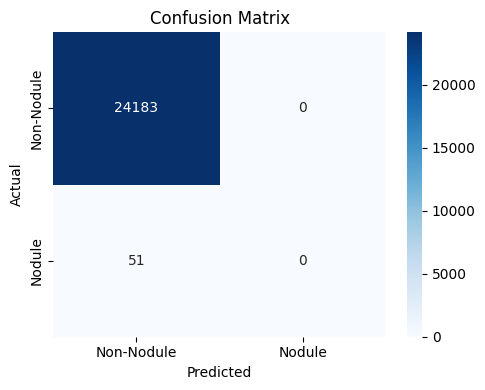


Classification Report:
              precision    recall  f1-score   support

  Non-Nodule       1.00      1.00      1.00     24183
      Nodule       0.00      0.00      0.00        51

    accuracy                           1.00     24234
   macro avg       0.50      0.50      0.50     24234
weighted avg       1.00      1.00      1.00     24234



C:\Users\Harsh\anaconda3\envs\lung_ai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Harsh\anaconda3\envs\lung_ai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Harsh\anaconda3\envs\lung_ai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [5]:
# =========================================
# MODEL EVALUATION: ACCURACY & CONFUSION MATRIX
# =========================================

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# ---- Force CPU ----
device = torch.device("cpu")
print("Using device:", device)

# ---- Paths ----
PROCESSED_DIR = r"C:\Users\Harsh\lung_cancer_detection\data\processed"
PATCH_DIR = os.path.join(PROCESSED_DIR, "patches_32")
MODEL_PATH = os.path.join(PROCESSED_DIR, "simple3dcnn_cpu.pth")

# ---- Dataset ----
class LungPatchDataset(Dataset):
    def __init__(self, patch_dir):
        self.files = sorted(os.listdir(patch_dir))
        self.patch_dir = patch_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        patch = np.load(os.path.join(self.patch_dir, fname)).astype(np.float32)

        # Normalize
        patch = (patch - patch.mean()) / (patch.std() + 1e-8)

        # Add channel dim
        patch = np.expand_dims(patch, axis=0)

        label = 1 if "label1" in fname else 0

        return (
            torch.tensor(patch, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long)
        )

# ---- DataLoader ----
dataset = LungPatchDataset(PATCH_DIR)
loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)

print("Total evaluation samples:", len(dataset))

# ---- Model ----
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ---- Load Model ----
model = Simple3DCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

print("Model loaded successfully.")

# ---- Inference ----
all_preds = []
all_labels = []

with torch.no_grad():
    for patches, labels in loader:
        outputs = model(patches)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# ---- Accuracy ----
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Nodule", "Nodule"],
    yticklabels=["Non-Nodule", "Nodule"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# ---- Detailed Classification Report ----
print("\nClassification Report:")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=["Non-Nodule", "Nodule"]
    )
)


# Since this model contains 24183 non nodule patches then we have to retrain model 

In [4]:
# =========================================
# 3D CNN TRAINING WITH CLASS-WEIGHTED LOSS
# =========================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import Counter

# ---- FORCE CPU ----
device = torch.device("cpu")
print("Using device:", device)

# ---- Paths ----
PROCESSED_DIR = r"C:\Users\Harsh\lung_cancer_detection\data\processed"
PATCH_DIR = os.path.join(PROCESSED_DIR, "patches_32")

# ---- Dataset ----
class LungPatchDataset(Dataset):
    def __init__(self, patch_dir):
        self.files = sorted(os.listdir(patch_dir))
        self.patch_dir = patch_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        patch = np.load(os.path.join(self.patch_dir, fname)).astype(np.float32)

        patch = (patch - patch.mean()) / (patch.std() + 1e-8)
        patch = np.expand_dims(patch, axis=0)

        label = 1 if "label1" in fname else 0

        return (
            torch.tensor(patch, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long)
        )

# ---- DataLoader ----
dataset = LungPatchDataset(PATCH_DIR)

loader = DataLoader(
    dataset,
    batch_size=8,   # small batch for CPU
    shuffle=True,
    num_workers=0
)

print("Total patches:", len(dataset))

# ---- Compute Class Weights ----
labels = [1 if "label1" in f else 0 for f in dataset.files]
class_counts = Counter(labels)

num_non_nodule = class_counts[0]
num_nodule = class_counts[1]

print("Class distribution:", class_counts)

# Inverse frequency weighting
weight_non_nodule = 1.0
weight_nodule = num_non_nodule / max(num_nodule, 1)

class_weights = torch.tensor(
    [weight_non_nodule, weight_nodule],
    dtype=torch.float32
)

print("Class weights:", class_weights)

# ---- 3D CNN Model ----
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ---- Initialize Model ----
model = Simple3DCNN().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Model initialized with class-weighted loss.")

# ---- Training Loop ----
EPOCHS = 5   # train a bit longer now

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    loop = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for patches, labels in loop:
        patches = patches.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(loader)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

# ---- Save Model ----
MODEL_PATH = os.path.join(PROCESSED_DIR, "simple3dcnn_weighted_cpu.pth")
torch.save(model.state_dict(), MODEL_PATH)
print("Weighted model saved to:", MODEL_PATH)


Using device: cpu
Total patches: 24234
Class distribution: Counter({0: 24183, 1: 51})
Class weights: tensor([  1.0000, 474.1765])
Model initialized with class-weighted loss.


Epoch 1/5: 100%|██████████| 3030/3030 [06:32<00:00,  7.73it/s, loss=0.00913] 


Epoch 1 - Avg Loss: 0.3695


Epoch 2/5: 100%|██████████| 3030/3030 [06:15<00:00,  8.08it/s, loss=0.00191] 


Epoch 2 - Avg Loss: 0.1221


Epoch 3/5: 100%|██████████| 3030/3030 [05:59<00:00,  8.42it/s, loss=0.0195]  


Epoch 3 - Avg Loss: 0.0978


Epoch 4/5: 100%|██████████| 3030/3030 [06:12<00:00,  8.14it/s, loss=0.0832]  


Epoch 4 - Avg Loss: 0.1434


Epoch 5/5: 100%|██████████| 3030/3030 [06:15<00:00,  8.06it/s, loss=0.0347]  

Epoch 5 - Avg Loss: 0.1273
Weighted model saved to: C:\Users\Harsh\lung_cancer_detection\data\processed\simple3dcnn_weighted_cpu.pth


Using device: cpu
Total evaluation samples: 24234
Weighted model loaded successfully.

Accuracy: 99.79%


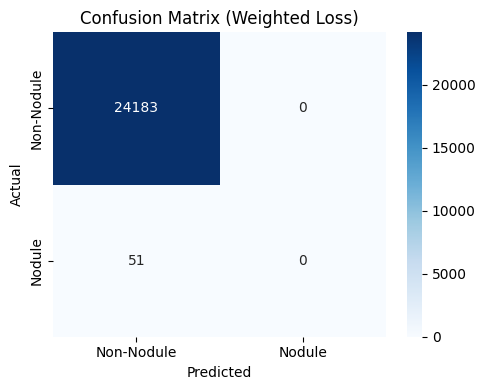


Classification Report:
              precision    recall  f1-score   support

  Non-Nodule       1.00      1.00      1.00     24183
      Nodule       0.00      0.00      0.00        51

    accuracy                           1.00     24234
   macro avg       0.50      0.50      0.50     24234
weighted avg       1.00      1.00      1.00     24234



C:\Users\Harsh\anaconda3\envs\lung_ai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Harsh\anaconda3\envs\lung_ai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Harsh\anaconda3\envs\lung_ai\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [1]:
# =========================================
# EVALUATION: WEIGHTED MODEL (CPU)
# Accuracy + Confusion Matrix + Recall
# =========================================

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# ---- FORCE CPU ----
device = torch.device("cpu")
print("Using device:", device)

# ---- Paths ----
PROCESSED_DIR = r"C:\Users\Harsh\lung_cancer_detection\data\processed"
PATCH_DIR = os.path.join(PROCESSED_DIR, "patches_32")
MODEL_PATH = os.path.join(PROCESSED_DIR, "simple3dcnn_weighted_cpu.pth")

# ---- Dataset ----
class LungPatchDataset(Dataset):
    def __init__(self, patch_dir):
        self.files = sorted(os.listdir(patch_dir))
        self.patch_dir = patch_dir

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        patch = np.load(os.path.join(self.patch_dir, fname)).astype(np.float32)

        patch = (patch - patch.mean()) / (patch.std() + 1e-8)
        patch = np.expand_dims(patch, axis=0)

        label = 1 if "label1" in fname else 0

        return (
            torch.tensor(patch, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long)
        )

# ---- DataLoader ----
dataset = LungPatchDataset(PATCH_DIR)
loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)

print("Total evaluation samples:", len(dataset))

# ---- Model Definition ----
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool3d(2)
        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ---- Load Weighted Model ----
model = Simple3DCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
model.eval()

print("Weighted model loaded successfully.")

# ---- Inference ----
all_preds = []
all_labels = []

with torch.no_grad():
    for patches, labels in loader:
        outputs = model(patches)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# ---- Accuracy ----
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Non-Nodule", "Nodule"],
    yticklabels=["Non-Nodule", "Nodule"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Weighted Loss)")
plt.tight_layout()
plt.show()

# ---- Classification Report ----
print("\nClassification Report:")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=["Non-Nodule", "Nodule"]
    )
)


# Models

# Lung Segmentation

In [ ]:
import torch
import torch.nn as nn

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(2)

        self.enc2 = block(32, 64)
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = block(64, 128)

        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = block(128, 64)

        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = block(64, 32)

        self.final = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b  = self.bottleneck(self.pool2(e2))

        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))


# Patch-Level Nodule Classification

In [ ]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv3d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv3d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool3d(2)

        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


# Class Imbalance Handling

In [ ]:
weights = torch.tensor([1.0, 400.0])
criterion = nn.CrossEntropyLoss(weight=weights)


# Nodule Type Classification

In [ ]:
self.fc2 = nn.Linear(128, 3)  # 3 nodule types
criterion = nn.CrossEntropyLoss()


# Malignancy Classification (SCLC vs NSCLC)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05
)

model.fit(X_train, y_train)


# Radiomics Feature Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15
)

rf.fit(X_train, y_train)


# Meta-Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

meta = LogisticRegression()
meta.fit(fused_features, labels)
